In [1]:
### PREAMBLE
# Chapter 1 - Introduction to adversarial robustness
# noise.jpg

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0431, 0.0667, 0.0706],
          [0.0000, 0.0000, 0.0000,  ..., 0.0471, 0.0784, 0.0863],
          [0.0000, 0.0000, 0.0000,  ..., 0.0549, 0.0863, 0.0980],
          ...,
          [0.1961, 0.2627, 0.4980,  ..., 0.7569, 0.6902, 0.6314],
          [0.0627, 0.1490, 0.3922,  ..., 0.6941, 0.6314, 0.6275],
          [0.1725, 0.2980, 0.4902,  ..., 0.6353, 0.6235, 0.6667]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0588, 0.0745, 0.0784],
          [0.0000, 0.0000, 0.0000,  ..., 0.0667, 0.0863, 0.0941],
          [0.0000, 0.0000, 0.0000,  ..., 0.0745, 0.0941, 0.1059],
          ...,
          [0.2824, 0.3490, 0.5804,  ..., 0.8392, 0.8000, 0.7373],
          [0.1412, 0.2235, 0.4706,  ..., 0.7647, 0.7137, 0.7098],
          [0.2392, 0.3647, 0.5569,  ..., 0.7020, 0.6902, 0.7333]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0118, 0.0235, 0.0275],
          [0.0000, 0.0000, 0.0000,  ..., 0.0196, 0.0353, 0.0431],
          [0.0000, 0.0000, 0.0000,  ..., 0

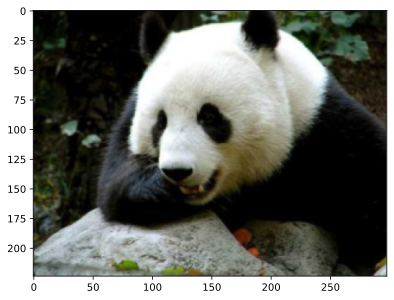

In [35]:
from PIL import Image
from torchvision import transforms
import torch

# read the image, resize to 224 and convert to PyTorch Tensor
pig_img = Image.open("/kaggle/input/imagenet-example/panda.jpeg")
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
pig_tensor = preprocess(pig_img)[None,:,:,:]
print(pig_tensor)

plt.imshow(pig_tensor[0].numpy().transpose(1,2,0))
for i in range(1,2):
    rand=torch.rand(1, 3, 224, 224)
    # plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
    plt.imshow(pig_tensor[0].numpy().transpose(1,2,0))

In [36]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images, 
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.eval();

In [37]:
# form predictions
pred = model(norm(pig_tensor))

In [38]:
import json
with open("/kaggle/input/imagenet-example/imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
print('Original Prediction (without adding noise): ', imagenet_classes[pred.max(dim=1)[1].item()])

Original Prediction (without adding noise):  giant_panda


In [39]:
# 388 is the class index corresponding to "giant_panda"
print(nn.CrossEntropyLoss()(model(norm(pig_tensor)),torch.LongTensor([388])).item())

0.02299954742193222


In [40]:
import torch.optim as optim
epsilon = 4./255

delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=1e-1)

for t in range(30):
    pred = model(norm(pig_tensor + delta))
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([388]))
    if t % 5 == 0:
        print(t, loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)
    
print("True class probability:", nn.Softmax(dim=1)(pred)[0,388].item())

0 -0.02299954742193222
5 -5.307411193847656
10 -19.8196964263916
15 -31.994943618774414
20 -29.453630447387695
25 -33.88488006591797
True class probability: 2.0015230995490928e-14


In [41]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  American_Staffordshire_terrier
Predicted probability: 0.9658479690551758


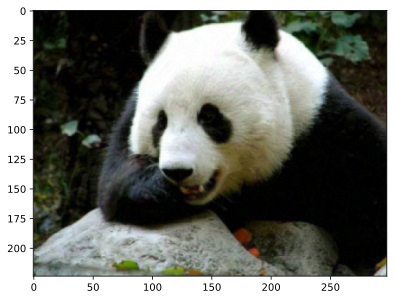

In [47]:
plt.imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))
data =  (pig_tensor + delta)[0].detach().numpy().transpose(1,2,0)
min_val = np.min(data)
max_val = np.max(data)
img_data_clamped = (data - min_val) / (max_val - min_val)
plt.imsave('panda_with_noise.png', img_data_clamped)

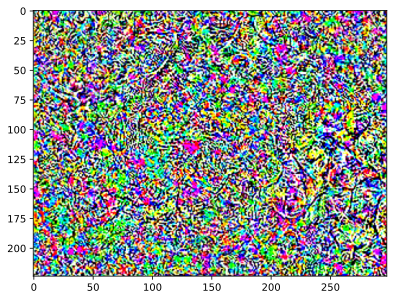

In [51]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))
noise = (50*delta+0.5)[0].detach().numpy().transpose(1,2,0)
min_val = np.min(noise)
max_val = np.max(noise)
img_data_clamped = (noise - min_val) / (max_val - min_val)
plt.imsave('noise.png',img_data_clamped)

In [53]:
plt.imsave('panda_without_noise.png',(pig_tensor)[0].detach().numpy().transpose(1,2,0))

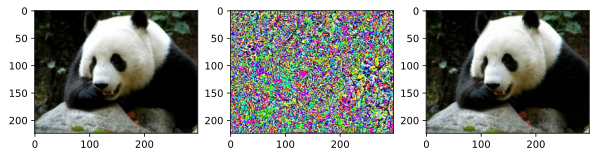

In [44]:
f,ax = plt.subplots(1,3, figsize=(10,5))
ax[0].imshow((pig_tensor)[0].detach().numpy().transpose(1,2,0))
ax[1].imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))
ax[2].imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))